In [1]:
library(Seurat)
library(Matrix)
library(dplyr)
library(tibble)
library(viridis)
inputdir <- "./load_files/"
outputdir <- "./report/"

source("./ptime.fun.v2.R")

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/Co

In [2]:
## Genearte region order based on expression
load(file = paste0(inputdir, "Smooth_by_region_oRG.Rdata"))  ##org_smt, org_meta, 
head(org_meta)
table(org_meta$region)

,region,pseudotime,cluster
,<chr>,<dbl>,<chr>
FC|9.506761,FC,9.506761,oRG HOPX TNC
FC|9.599064,FC,9.599064,oRG HOPX TNC
FC|9.691368,FC,9.691368,oRG HOPX TNC
FC|9.783671,FC,9.783671,oRG HOPX TNC
FC|9.875975,FC,9.875975,oRG HOPX TNC
FC|9.968278,FC,9.968278,oRG HOPX TNC



 FC MSC OcC  TC 
100 100 100 100 

In [3]:
## Reorder org_smt columns, put TC after OC
org_smt_new_ord <- lapply(c("FC", "MSC", "OcC", "TC"), function(x) {
    yy <- colnames(org_smt)[grepl(paste0("^", x, "\\|"), colnames(org_smt))]
    return(yy)
    }) %>%
    unlist()
org_smt <- org_smt[, org_smt_new_ord]
org_meta <- org_meta[org_smt_new_ord, ]

In [4]:
load(file = paste0(inputdir, "Region_DEGs_res_v2.rds"))
# vrg_deg, org_deg, vrg_res, org_res, cbn_res
res_use <- org_res %>%
            mutate(cluster_idx = as.numeric(factor(as.character(cluster), 
                                                   levels = c("oRG HOPX TNC", "oRG HOPX APOE"))))
head(res_use)
meta_use <- org_meta
smt_use <- org_smt

,gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,ratio_fc,region,cluster,cluster_idx
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,SPARCL1,1.103786e-34,1.0206344,0.821,0.448,3.821197e-30,1.814410,FC,oRG HOPX APOE,2
2,RAMP2,6.117476e-28,0.8728951,0.464,0.112,2.117809e-23,3.885246,FC,oRG HOPX APOE,2
3,GLUL,2.014854e-21,0.6914524,0.771,0.532,6.975221e-17,1.440959,FC,oRG HOPX APOE,2
4,LUZP2,2.835952e-18,0.6830907,0.439,0.159,9.817782e-14,2.656805,FC,oRG HOPX APOE,2
5,SPHK1,1.369615e-17,0.5099013,0.251,0.039,4.741472e-13,5.326531,FC,oRG HOPX APOE,2
6,CRYM,1.672647e-17,0.6999270,0.735,0.470,5.790536e-13,1.552083,FC,oRG HOPX APOE,2


In [5]:
## Order genes based on 
## 1. clusters showing enrichment
## 2. cut time.on to bins, order by bins, then order by time
## Load Impulse Fit results to order genes
timeres <- readRDS(file = paste0(inputdir, "Order_by_EXPR_oRG_v4.rds"))
order_genes <- lapply(names(timeres), function(reg) {
    xx <- timeres[[reg]]
    maxval <- max(meta_use$pseudotime[meta_use$region == reg])

    xx$time.on[xx$time.on < 0] <- -0.001
    xx$time.off[xx$time.off > ceiling(maxval)] <- ceiling(maxval) + 1

    ## Add the cell type each gene enriched in
    sub_res <- res_use %>%
                filter(region == reg)
    xx$cluster_idx <- sapply(1:nrow(xx), function(idx) min(sub_res$cluster_idx[sub_res$gene == xx$gene[[idx]]])) 

    xx$start.bin <- as.numeric(cut(xx$time.on, 8))
    xx$end.bin <- as.numeric(cut(xx$time.off, 8))

    yy <- xx$gene[order(xx$start.bin, xx$end.bin, xx$time.on, xx$time.off, decreasing = FALSE)] ##xx$cluster_idx, 
    yy
    }) %>%
    setNames(., names(timeres)) %>%
    .[c("FC", "MSC", "OcC", "TC")]
all_visgenes <- unlist(order_genes) %>% unique()
all_visgenes
    

[1] "LOC106997086" "DCT"          "RBP1"         "S100A6"       "ZIC1"        
  [6] "PPP2R2B"      "SPARCL1"      "GLUL"         "CRYM"         "S100A16"     
 [11] "ABHD6"        "CXXC4"        "LUZP2"        "RAMP2"        "SPHK1"       
 [16] "ATP6"         "IL11RA"       "MYBPC1"       "MMRN1"        "HES5"        
 [21] "EEF1A1"       "FOS"          "PKIA"         "SLC35F1"      "FXYD1"       
 [26] "LOC100499503" "POU3F2"       "HGF"          "EFNB2"        "LOC707085"   
 [31] "HIST1H1E"     "SPTBN1"       "PENK"         "LOC716530"    "PPP1R17"     
 [36] "CD9-1"        "DCN"          "LYN"          "RPS4Y1"       "MDFI"        
 [41] "RALGAPA2"     "B3GAT2"       "LRRC3B"       "OLFM2"        "LOC109910386"
 [46] "SLC1A2"       "DAAM2"        "BHLHE22"      "CBX5"         "MEF2C"       
 [51] "NFIX"         "LOC114672293" "CXCL14"       "NPY"          "OTUD6B"      
 [56] "NR2F1"        "CST3"         "PET100"       "PALMD"        "CTTNBP2"     
 [61] "ARC"          "IER2"         "PAQR8"        "LOC693820"    "TACSTD2"     
 [66] "FGFR3"        "GAP43"        "LAMP3"        "TMSB15B.1"    "CKS2"        
 [71] "SPARC"        "PMVK"         "RHBDL3"       "CXCL12"       "EPHA7"       
 [76] "ADRA1A"       "LOC709583"    "PNOC"         "UCP2"         "PLD5"        
 [81] "LOC706246"    "CRH"          "SFRP2"        "ITM2C"        "CPNE4"       
 [86] "FLNC"         "NTRK2"        "ANOS1"        "SNCA"         "KCNN3"       
 [91] "AGT"          "FSTL5"        "FAM172A"      "CADM1"        "CHRNE"       
 [96] "SPOCK2"       "IGFBP5"       "LRRN1"        "PCSK1N"       "NR2F2"       
[101] "TRIL"         "TSPAN18"      "COL4A6"       "SLC44A1"      "FBLN1"

In [6]:
## Generate scaled average expression & change row names
svg <- smt_use[all_visgenes, ,drop = FALSE] %>%
            as.matrix() %>%
            t() %>% scale() %>% t() %>%
            MinMax(., min = -1.5, max = 2.5)
svg[is.na(svg)] <- -1.5
exp_mat <- lapply(names(order_genes), function(reg) {
    mat <- as.matrix(svg[order_genes[[reg]], ,drop = FALSE])
    rownames(mat) <- paste0(reg, "|", rownames(mat))
    return(mat)
    }) %>%
    do.call(rbind, .)
head(exp_mat)

,FC|9.506761,FC|9.599064,FC|9.691368,FC|9.783671,FC|9.875975,FC|9.968278,FC|10.060582,FC|10.152885,FC|10.245189,FC|10.337492,⋯,TC|17.814071,TC|17.906374,TC|17.998678,TC|18.090981,TC|18.183285,TC|18.275588,TC|18.367892,TC|18.460195,TC|18.552499,TC|18.644802
FC|LOC106997086,2.5000000,2.50000000,2.5000000,2.50000000,2.5000000,2.5000000,2.5000000,2.5000000,2.5000000,2.4920300,⋯,-0.6421658,-0.6421658,-0.6421658,-0.6421658,-0.6421658,-0.6421658,-0.6421658,-0.6421658,-0.6421658,-0.6421658
FC|DCT,2.5000000,2.50000000,2.5000000,2.50000000,2.5000000,2.5000000,2.5000000,2.5000000,2.5000000,2.5000000,⋯,-0.4289289,-0.4296672,-0.4307508,-0.4321745,-0.4339336,-0.4360228,-0.4384371,-0.4411716,-0.4442212,-0.4475808
FC|RBP1,2.5000000,2.50000000,2.5000000,2.50000000,2.5000000,2.5000000,2.5000000,2.5000000,2.5000000,2.5000000,⋯,-1.1849990,-1.2017803,-1.2179860,-1.2336285,-1.2487206,-1.2632748,-1.2773039,-1.2908203,-1.3038368,-1.3163659
FC|S100A6,-0.1658887,-0.09633637,-0.0279298,0.04040584,0.1097483,0.1811724,0.2551955,0.3303675,0.4063166,0.4828038,⋯,-1.1653168,-1.2240412,-1.2842081,-1.3458295,-1.4089201,-1.4734919,-1.5000000,-1.5000000,-1.5000000,-1.5000000
FC|ZIC1,2.5000000,2.50000000,2.5000000,2.50000000,2.5000000,2.5000000,2.4855248,2.3850413,2.2871219,2.1918076,⋯,-0.5194332,-0.5145550,-0.5095801,-0.5045066,-0.4993327,-0.4940564,-0.4886759,-0.4831894,-0.4775948,-0.4718905
FC|PPP2R2B,1.1118884,1.12058794,1.1286022,1.13587338,1.1423439,1.1479560,1.1526948,1.1566775,1.1599191,1.1624235,⋯,-1.5000000,-1.5000000,-1.5000000,-1.5000000,-1.5000000,-1.5000000,-1.5000000,-1.5000000,-1.4421605,-1.3526126


In [7]:
## Label genes
## system("cp ~/project/public_data/MEME_db/custom_motif/DatabaseExtract_v_1.01.csv ../overview/load_files/")
tfs <- read.csv(file = "../overview/load_files/DatabaseExtract_v_1.01.csv", 
                stringsAsFactors = FALSE) %>%
            subset(Is.TF. == "Yes") %>%
            .$HGNC.symbol %>% 
            unique()
cus_genes <- readLines(paste0(inputdir, "genes2label.oRG.txt"))
reg_genes <- lapply(c("FC", "MSC", "OcC", "TC"), function(reg) {
            interest <- union(tfs, cus_genes)
            if (sum(interest %in% order_genes[[reg]]) > 0){
                return(paste0(reg, "|", intersect(order_genes[[reg]], interest)))
            }
            }) %>%
            setNames(., c("FC", "MSC", "OcC", "TC")) %>%
            lapply(., function(x) setNames(sapply(strsplit(x, "|", fixed = TRUE), "[", 2), x))
sel_genes <- list(left = c(reg_genes[["FC"]], reg_genes[["OcC"]]),
            right = c(reg_genes[["MSC"]], reg_genes[["TC"]]))
sel_genes
                   

$left
     FC|DCT     FC|RBP1   FC|S100A6     FC|ZIC1  FC|SPARCL1    FC|CXXC4 
      "DCT"      "RBP1"    "S100A6"      "ZIC1"   "SPARCL1"     "CXXC4" 
    FC|HES5      FC|FOS   FC|POU3F2      FC|HGF    FC|EFNB2    OcC|PENK 
     "HES5"       "FOS"    "POU3F2"       "HGF"     "EFNB2"      "PENK" 
    OcC|DCN  OcC|B3GAT2  OcC|SLC1A2     OcC|FOS OcC|BHLHE22   OcC|MEF2C 
      "DCN"    "B3GAT2"    "SLC1A2"       "FOS"   "BHLHE22"     "MEF2C" 
   OcC|NFIX  OcC|CXCL14     OcC|NPY   OcC|NR2F1 
     "NFIX"    "CXCL14"       "NPY"     "NR2F1" 

$right
 MSC|SPARCL1 MSC|HIST1H1E   MSC|SPTBN1     TC|FGFR3     TC|SFRP2     TC|NTRK2 
   "SPARCL1"   "HIST1H1E"     "SPTBN1"      "FGFR3"      "SFRP2"      "NTRK2" 
    TC|KCNN3     TC|NR2F2     TC|NR2F1 
     "KCNN3"      "NR2F2"      "NR2F1"

[1] "FC|LOC106997086" "FC|DCT"          "FC|RBP1"         "FC|S100A6"      
[5] "FC|ZIC1"         "FC|PPP2R2B"

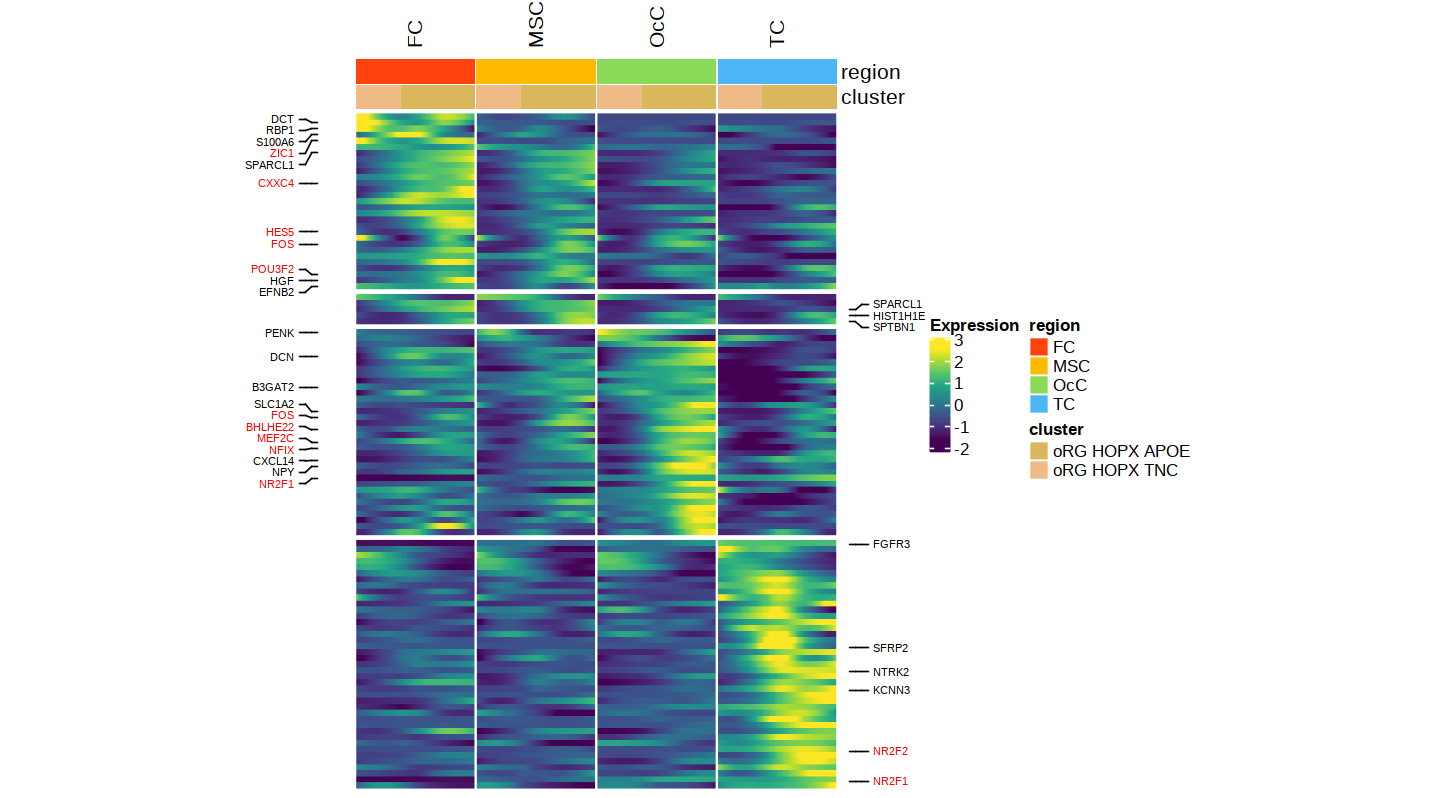

In [8]:
## Highlight TFs as red text
source("./ptime.fun.v2.R")
high_genes <- lapply(c("FC", "MSC", "OcC", "TC"), function(reg) paste0(reg, "|", tfs)) %>%
            unlist()
rsplit <- strsplit(rownames(exp_mat),"|",fixed = TRUE) %>%
            sapply(., "[", 1) %>%
            setNames(., NULL) %>%
            factor(., levels = c("FC", "MSC", "OcC", "TC"))
head(rownames(exp_mat))


## Plot
ht1 <- plot_heatmap.RGCcascade.regionshare(mat = exp_mat, 
            meta = meta_use, 
            label_genes = sel_genes, 
            color_breaks = seq(-1.5, 2.5, 0.5), 
            file_name = paste0("Expr_byExpr_oRG"), 
            pdf_height = 6, 
            row_split = rsplit, highlight_genes = high_genes, fontsize = 6)

options(repr.plot.width=12, repr.plot.height=6.65)
draw(ht1)
## the row_split parameter doesn't work well in the jupyter notebook, so the gene labels are not aligned well unless
## output it to a pdf file

In [9]:
pdf("./report/Expr_byExpr_oRG_v2.selected.pdf", width = 12, height = 7)
draw(ht1)
dev.off()

png 
  2

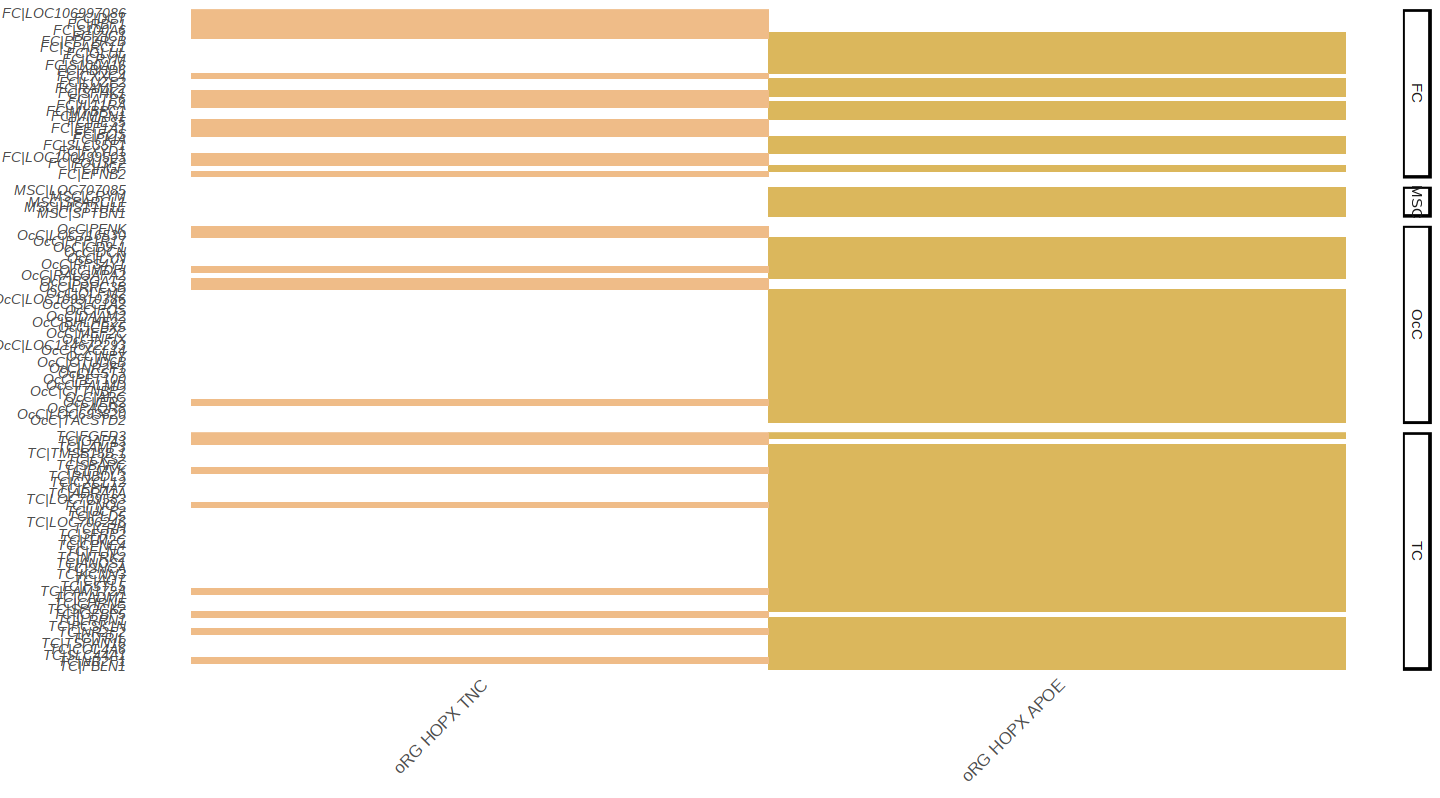

In [10]:
##------------------------------------------------------------------------------------------
## Plot annotation
#"#fc19cf", 
cls_cols <- c("#e25a9a", "#1ac9a9", "#a3c10d", 
        "#efbc88", "#dbb75c", "#6700e5", "#7133aa", "#003563"
        ) %>%
                setNames(., c("NEP RSPO3", "vRG HMGA2 CCND1", "vRG SAT1 STMN2", 
                    "oRG HOPX TNC", "oRG HOPX APOE", 
                    "tRG CRYAB MEST", "tRG CRYAB FNDC1", "Ependymal"))
sel_cls <- c("oRG HOPX TNC", "oRG HOPX APOE")
reggene_ord <- lapply(names(order_genes), function(reg) paste0(reg, "|", order_genes[[reg]])) %>%
                unlist()
ctp_annot <- res_use %>%
            mutate(cluster = factor(as.character(cluster), levels = sel_cls)) %>%
            mutate(reggene = paste0(region, "|", gene)) %>%
            mutate(reggene = factor(reggene, levels = rev(reggene_ord))) %>%
            mutate(region = factor(region, levels = c("FC", "MSC", "OcC", "TC"))) %>%
            mutate(fillcol = cls_cols[as.character(cluster)])
p1 <- ggplot(ctp_annot, aes_string(x = "cluster", y = "reggene", fill = "fillcol")) + 
            geom_tile(color = NA, size = 1) +
            ##scale_fill_manual(values = c(`0` = "lightgrey", `1` = "black")) +
            scale_fill_identity() +
            theme_classic() + 
            RotatedAxis() + 
            facet_grid(rows = vars(region), space = "free_y", scales = "free_y") +
            theme(axis.line = element_blank(), 
                  axis.ticks = element_blank(), 
                  axis.title = element_blank(), 
                  axis.text.y = element_text(size = 8, face = "italic"), 
                  axis.text.x = element_text(size = 10))
p1

In [11]:
pdf(paste0(outputdir, "Expr_byExpr_oRG_v2.annot-region.pdf"), width = 4, height = 7)
print(p1)
dev.off()

png 
  2

In [12]:
##------------------------------------------------------------------------------------------
## Save the results as table
allcls <- c("oRG HOPX TNC", "oRG HOPX APOE")
enr_mat <- matrix(0, nrow = nrow(exp_mat), ncol = length(allcls), dimnames = list(rownames(exp_mat), allcls))
for (ii in rownames(enr_mat)){
    cls <- ctp_annot$cluster[ctp_annot$reggene %in% ii]
    if (length(cls) >= 1){
        for (jj in cls){
            enr_mat[ii, jj] <- 1
        } 
    }
}



df <- data.frame(reg_gene = rownames(exp_mat),
            stringsAsFactors = FALSE) %>%
            mutate(region = sapply(strsplit(reg_gene, "|", fixed = TRUE), "[", 1), 
               gene = sapply(strsplit(reg_gene, "|", fixed = TRUE), "[", 2)) %>%
            mutate(isTF = ifelse(gene %in% tfs, "Y", "N")) %>%
            cbind(., enr_mat)
df$time.on <- NA
df$time.off <- NA
for (ii in 1:nrow(df)){
    reg <- df$region[ii]
    gene <- df$gene[ii]
    timedata <- timeres[[reg]]

    df$time.on[ii] <- round(timedata$time.on[timedata$gene %in% gene], digits = 5)
    df$time.off[ii] <- round(timedata$time.off[timedata$gene %in% gene], digits = 5)
    if (df$time.on[ii] > df$time.off[ii]){
        df$time.off[ii] <- 100
    }
}
df$time.on <- MinMax(df$time.on, min = -100, max = 100)
df$time.off <- MinMax(df$time.off, min = 0, max = 100)


df <- df[, c("region", "gene", "isTF", colnames(enr_mat), "time.on", "time.off")]
df$region <- gsub("^FC$", "FR", df$region) %>%
                gsub("MSC", "MS", .) %>%
                gsub("TC", "Tem", .) %>%
                gsub("OcC", "OC", .)

colnames(df) <- c("Enriched region", "Gene", "is TF?", 
                  paste0("Enriched in ", colnames(enr_mat)), "Pseudotime on", "Pseudotime off")
df

,Enriched region,Gene,is TF?,Enriched in oRG HOPX TNC,Enriched in oRG HOPX APOE,Pseudotime on,Pseudotime off
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
FC|LOC106997086,FR,LOC106997086,N,1,0,-100.00000,9.50676
FC|DCT,FR,DCT,N,1,0,-100.00000,10.14964
FC|RBP1,FR,RBP1,N,1,0,-100.00000,14.23650
FC|S100A6,FR,S100A6,N,1,0,-100.00000,15.43042
FC|ZIC1,FR,ZIC1,Y,1,1,-28.19618,100.00000
FC|PPP2R2B,FR,PPP2R2B,N,0,1,-100.00000,100.00000
FC|SPARCL1,FR,SPARCL1,N,0,1,9.50676,100.00000
FC|GLUL,FR,GLUL,N,0,1,9.50676,100.00000
FC|CRYM,FR,CRYM,N,0,1,9.50676,100.00000


In [13]:
write.table(df, file = "./report/table_Sxx_NSC_progression_oRG.txt", 
            row.names = FALSE, col.names = TRUE, sep = "\t", quote = FALSE)

In [14]:
## Load pathway genes
## Load signaling-related genes & intersect
source("./ptime.fun.v2.R")
path_gset <- readRDS("../../MF2_organizer/overview/load_files/Pathway_updated_20221219.rds")
sapply(path_gset, head)

BMP,EPH,FGF,NOTCH,WNT,RA,SHH
BMPR2,EPHB2,AKT1,ADAM17,APC,UGT1A3,TTC26
SMAD1,EFNB1,BGLAP,APH1A,APC2,SERPINA5,DISP2
SMAD4,EFNB2,CAMK2A,CIR1,AXIN1,UGT2B15,WNT10B
SMAD6,EPHB1,RUNX2,CREBBP,AXIN2,CYP27C1,CFAP410
NOG,EPHB3,CBL,CTBP1,BTRC,UGT2B7,ZIC3
SMURF1,EPHB4,CDH1,CTBP2,CACYBP,UGT1A8,GPR37L1


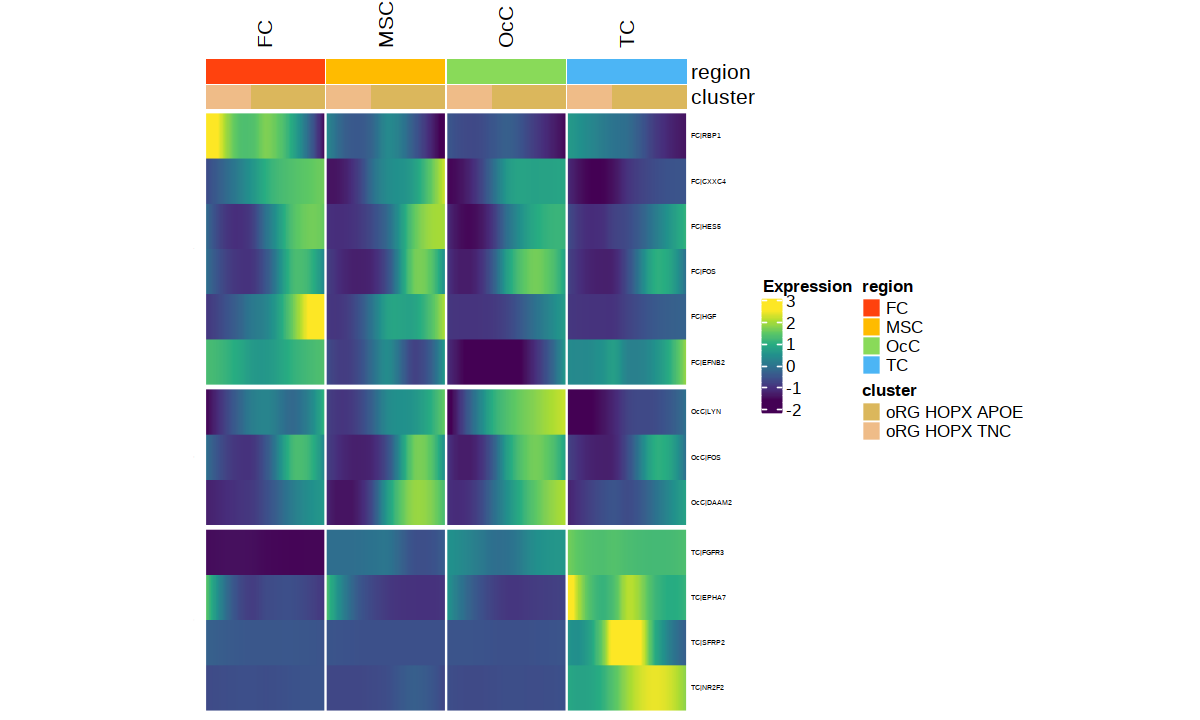

In [15]:
all_siggenes <- unlist(path_gset) %>% unique()
order_genes <- lapply(order_genes, function(x) intersect(x, all_siggenes))
order_genes <- order_genes[sapply(order_genes, length) > 0]
all_visgenes <- unlist(order_genes) %>% unique()


## Generate scaled average expression & change row names
svg <- smt_use[all_visgenes, ,drop = FALSE] %>%
            as.matrix() %>%
            t() %>% scale() %>% t() %>%
            MinMax(., min = -1.5, max = 2.5)
svg[is.na(svg)] <- -1.5
exp_mat <- lapply(names(order_genes), function(reg) {
    mat <- as.matrix(svg[order_genes[[reg]], ,drop = FALSE])
    rownames(mat) <- paste0(reg, "|", rownames(mat))
    return(mat)
    }) %>%
    do.call(rbind, .)

rsplit <- sapply(strsplit(rownames(exp_mat), "|", fixed = TRUE), "[", 1) %>%
            setNames(., NULL) %>%
            factor(., levels = c("FC", "MSC", "OcC", "TC"))

## Plot
ht2 <- plot_heatmap.RGCcascade(mat = exp_mat, 
                               meta = meta_use, 
                               label_genes = NULL, 
                               color_breaks = seq(-1.5, 2.5, 0.5), 
                               file_name = paste0("Expr_byExpr_oRG_Signaling"), 
                               pdf_height = 6, 
                               row_split = rsplit, highlight_genes = NULL, fontsize = 6)
options(repr.plot.width=10, repr.plot.height=6)
draw(ht2)

In [16]:
pdf("./report/Expr_byExpr_oRG_Signaling_heatmap.pdf", width = 10, height = 6)
draw(ht2)
dev.off()

png 
  2

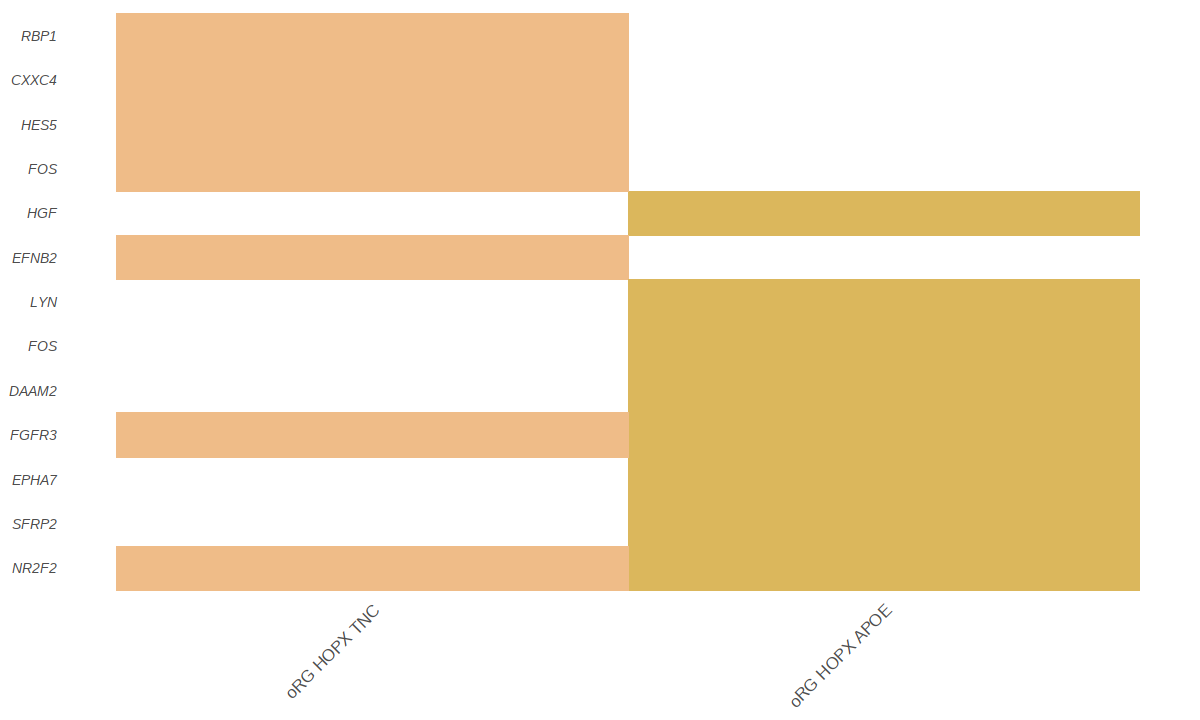

In [17]:
##------------------------------------------------------------------------------------------
## Plot annotation
cls_cols <- c("#e25a9a", "#1ac9a9", "#a3c10d", 
    "#efbc88", "#dbb75c", "#6700e5", "#7133aa", "#003563"
    ) %>%
            setNames(., c("NEP RSPO3", "vRG HMGA2 CCND1", "vRG SAT1 STMN2", 
                "oRG HOPX TNC", "oRG HOPX APOE", 
                "tRG CRYAB MEST", "tRG CRYAB FNDC1", "Ependymal"))
sel_cls <- c("oRG HOPX TNC", "oRG HOPX APOE")
reggene_ord <- lapply(names(order_genes), function(reg) paste0(reg, "|", order_genes[[reg]])) %>%
                unlist()
ctp_annot <- res_use %>%
                mutate(cluster = factor(as.character(cluster), levels = sel_cls)) %>%
                mutate(reggene = paste0(region, "|", gene)) %>%
                filter(reggene %in% reggene_ord) %>%
                mutate(reggene = factor(reggene, levels = rev(reggene_ord))) %>%
                mutate(region = factor(region, levels = c("FC", "MSC", "OcC", "TC"))) %>%
                mutate(fillcol = cls_cols[as.character(cluster)])
y_labels <- sapply(strsplit(rev(reggene_ord), "|", fixed = TRUE), "[", 2) %>%
                setNames(., rev(reggene_ord))
p1 <- ggplot(ctp_annot, aes_string(x = "cluster", y = "reggene", fill = "fillcol")) + 
                geom_tile(color = NA, size = 1) +
                ##scale_fill_manual(values = c(`0` = "lightgrey", `1` = "black")) +
                scale_fill_identity() +
                theme_classic() + 
                scale_y_discrete(labels = y_labels) +
                RotatedAxis() + 
                ##facet_grid(rows = vars(region), space = "free_y", scales = "free_y") +
                theme(axis.line = element_blank(), axis.ticks = element_blank(), 
                      axis.title = element_blank(), 
                      axis.text.y = element_text(size = 8, face = "italic"), 
                      axis.text.x = element_text(size = 10))
p1
##pdf(paste0("./report/", "Expr_byExpr_oRG_Signaling_v2.annot-region.pdf"), width = 4, height = 6)
##print(p1)
##dev.off()

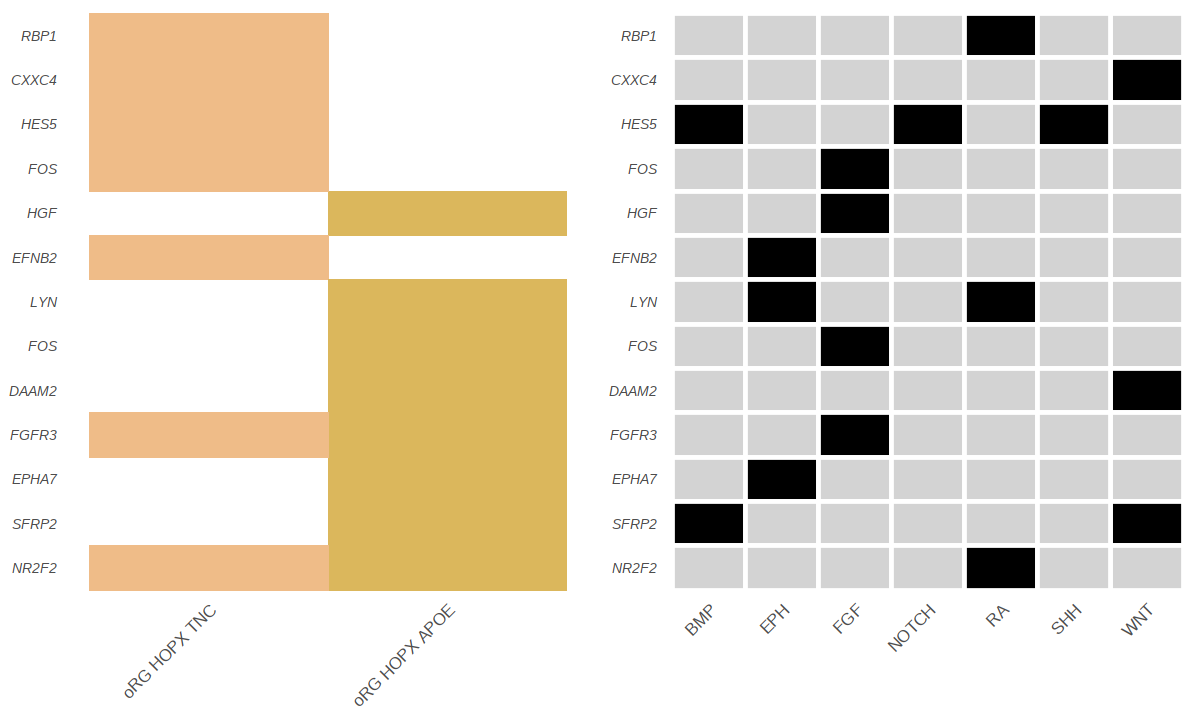

In [18]:
## Plot pathway annotation
anno_mat <- lapply(names(path_gset), function(sig) {
            genes <- sapply(strsplit(reggene_ord, "|", fixed = TRUE), "[", 2)
            value <- setNames(ifelse(genes %in% path_gset[[sig]], 1, 0), reggene_ord)
            value
            }) %>%
            setNames(., names(path_gset)) %>%
            as.data.frame(., check.names = FALSE) %>%
            rownames_to_column("reggene") %>%
            tidyr::gather(., "pathway", "value", names(path_gset)) %>%
            mutate(pathway = factor(pathway, levels = c("BMP", "EPH", "FGF", "NOTCH", "RA", "SHH", "WNT"))) %>%
            mutate(reggene = factor(reggene, levels = rev(reggene_ord))) %>%
            mutate(fillcol = ifelse(value == 1, "black", "lightgrey"))

p2 <- ggplot(anno_mat, aes_string(x = "pathway", y = "reggene", fill = "fillcol")) + 
            geom_tile(color = "white", size = 1) +
            scale_fill_identity() +
            theme_classic() + 
            scale_y_discrete(labels = y_labels) +
            RotatedAxis() + 
            ##facet_grid(rows = vars(region), space = "free_y", scales = "free_y") +
            theme(axis.line = element_blank(), axis.ticks = element_blank(), axis.title = element_blank(), 
                  axis.text.y = element_text(size = 8, face = "italic"), axis.text.x = element_text(size = 10))
panno <- cowplot::plot_grid(p1, p2, align = "h")
panno

In [19]:
pdf(paste0("./report/", "Expr_byExpr_oRG_Signaling_v2.annot-region.pdf"), width = 6, height = 6)
print(panno)
dev.off()

png 
  2

In [20]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/Tools/Anaconda3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] tidyr_1.1.3          ggforce_0.3.1        scatterpie_0.1.5    
 [4] ggplot2_3.3.0        ComplexHeatmap_2.2.0 circlize_0.4.13     
 [7] viridis_0.5.1        viridisLite_0.3.0    tibble_3.0.1        
[10] dplyr_1.0.7          Matrix_1.5-3     